In [1]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import pipeline

import torch

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt).to(device)


question = "how much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on file size."""

/home/karvsmech/miniconda3/envs/ptorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
inputs = tokenizer(question, context, return_tensors='pt').to(device)
print(tokenizer.decode(inputs['input_ids'][0]))

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

print(f'the shape of the input id is: {inputs.input_ids.size()}')
print(f'start logits shape: {outputs.start_logits.size()}')
print(f'end logits shape: {outputs.end_logits.size()}')

start_idx = torch.argmax(outputs.start_logits).cpu().numpy()
end_idx = torch.argmax(outputs.end_logits).cpu().numpy()
answer_span = inputs['input_ids'][0][start_idx:end_idx+1]
answer = tokenizer.decode(answer_span)
print(f'Question:{question}')
print(f'Answer:{answer}')

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so about 6000 hours depending on file size. [SEP]
QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]], device='cuda:0'), end_logits=tensor([[-0.9622, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0162, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]], device='cuda:0'), hidden_states=None, attentions=None)
the shape of the input id is: torch.Size([1, 28])
start logits shape: torch.Size([1, 28])
end logits shape: torch.Size([1, 28])
Question:how much music can this

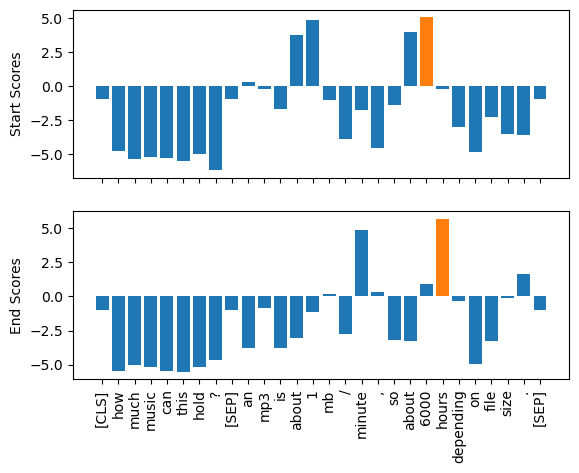

In [3]:
import numpy as np
import matplotlib.pyplot as plt

s_scores = outputs.start_logits.cpu().numpy().flatten()
e_scores = outputs.end_logits.cpu().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
token_ids = range(len(tokens))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=token_ids, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=token_ids, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(token_ids, tokens, rotation="vertical")
plt.show()

In [7]:
pipe = pipeline(task='question-answering', 
                model=model, 
                tokenizer=tokenizer, 
                device=device)
pipe(question=question, context=context, topk=3, handle_impossible_answer=True)

[{'score': 0.2651630640029907, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082920372486115,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253427922725677,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [9]:
# empty answers.
pipe(question='why is there no date?', context=context, handle_impossible_answer=True)

{'score': 0.9648663997650146, 'start': 0, 'end': 0, 'answer': ''}